# The `Well` object

Some preliminaries...

In [14]:
import numpy as np
import matplotlib.pyplot as plt

import welly
welly.__version__

'0.5.2'

## Load a well from LAS

In the Quick Start guide you saw how to quickly create a Project from a well with:

```python
import welly
project = welly.from_las('path/to/well.las')
```

A `welly.Project` is a collection of `welly.Well` objects. But if you only have a single well, you may not need a Project; a Well object on its own will do. Then you could do this:

```python
well, = welly.from_las('path/to/well.las')
```

The presence of the comma after `well` unpacks the single item into the `welly` variable. (This is a Python trick, it's not a Welly thing.)

Alternatively, you can use the `Well.from_las()` method to load a well by passing a filename as a `str`. This is really just a wrapper for `lasio` but instantiates a `Header`, `Curve`s, etc.

In [ ]:
from welly import Well

well = Well.from_las('https://geocomp.s3.amazonaws.com/data/P-129.LAS')
well

The Location is not stored correctly, with latitude stored in Section and Longitude stored in Township. Also the UWI is wrong (at the top). We can fix all this by 'remapping' some fields. This is done with a dictionary that maps a well's field to its location in the LAS file. For example, we can use the Well field ('Kennetcook #2') to as the UWI in our well with a mapping like: `{'UWI': 'WELL'}`. We can remove a bad item such as the Section name, by mapping to `None`:

In [15]:
remap = {
    'UWI': 'WELL',
    'KB': 'EKB',
    'LATI': 'SECT',
    'LONG': 'TOWN',
    'SECT': None,
    'TOWN': None,
    'LOC': None
}

well = Well.from_las('data/P-129_out.LAS', remap=remap)
well

Only engine='normal' can read wrapped files


Well(uwi: 'Kennetcook #2', name: 'Kennetcook #2', 24 curves: ['CALI', 'HCAL', 'PEF', 'DT', 'DTS', 'DPHI_SAN', 'DPHI_LIM', 'DPHI_DOL', 'NPHI_SAN', 'NPHI_LIM', 'NPHI_DOL', 'RLA5', 'RLA3', 'RLA4', 'RLA1', 'RLA2', 'RXOZ', 'RXO_HRLT', 'RT_HRLT', 'RM_HRLT', 'DRHO', 'RHOB', 'GR', 'SP'])

## Well header

Metadata about the well is stored in its `header` attribute:

In [16]:
well.header

,original_mnemonic,mnemonic,unit,value,descr,section
0,VERS,VERS,,2.0,,Version
1,WRAP,WRAP,,YES,,Version
2,STRT,STRT,M,1.0668,START DEPTH,Well
3,STOP,STOP,M,1939.1376,STOP DEPTH,Well
4,STEP,STEP,M,0.1524,STEP,Well
...,...,...,...,...,...,...
137,TLI,TLI,M,280.0,Top Log Interval,Parameter
138,UWID,UWID,,,Unique Well Identification Number,Parameter
139,WN,WN,,Kennetcook #2,Well Name,Parameter
140,EPD,EPD,M,90.300003,Elevation of Permanent Datum above Mean Sea Level,Parameter


### Important note

At present, the well's `header` contains a DataFrame with the entire LAS file header.

In a future release, only the well information from the **WELL** part of the file will be stored in the well's header. (The Params data goes into the `well.location` attribute, and the Curve data goes into Welly's `Curve` objects.)

## Well location

The well's `location` contains the location info from **PARAMS**, and will also store the well's 3D positional information, if available.

In [17]:
well.location

Location({'position': None, 'crs': CRS({}), 'country': 'CA', 'province': 'Nova Scotia', 'latitude': '45.20 Deg N', 'longitude': '63.75 Deg W', 'datum': '', 'range': 'PD 176', 'ekb': np.float64(94.8), 'egl': np.float64(90.3), 'kb': np.float64(94.8), 'gl': np.float64(90.3), 'tdd': np.float64(1935.0), 'tdl': np.float64(1935.0), 'td': None, 'deviation': None})

The CRS for this well is missing; we can add one if we know it:

In [18]:
well.location.crs = welly.CRS.from_epsg(2038)

well.location

Location({'position': None, 'crs': CRS({'init': 'epsg:2038', 'no_defs': True}), 'country': 'CA', 'province': 'Nova Scotia', 'latitude': '45.20 Deg N', 'longitude': '63.75 Deg W', 'datum': '', 'range': 'PD 176', 'ekb': np.float64(94.8), 'egl': np.float64(90.3), 'kb': np.float64(94.8), 'gl': np.float64(90.3), 'tdd': np.float64(1935.0), 'tdl': np.float64(1935.0), 'td': None, 'deviation': None})

Right now there's no position log — we need to load a deviation survey.

In [19]:
well.location.position

## Add deviation data to a well

Let's load another well:

In [20]:
import numpy as np
from welly import Well

well = Well.from_las('data/P-130_out.LAS')

In [23]:
dev = np.loadtxt('data/P-130_deviation_survey.csv', delimiter=',', skiprows=1)

The columns are MD, inclination, azimuth, and TVD.

In [24]:
dev[:5]

array([[ 18. ,   0.3,   0. ,  18. ],
       [ 38. ,   0.5,   0. ,  38. ],
       [ 57. ,   1.5,   0. ,  57. ],
       [ 84. ,   1.8,   0. ,  84. ],
       [104. ,   0.5,   0. , 104. ]])

`add_deviation` assumes those are the columns, and computes a position log.

In [ ]:
p.location.add_deviation(dev[:, :3], td=2618.3)

The columns in the position log are _x_ offset, _y_ offset, and TVD.

In [ ]:
p.location.position[:5]

In [ ]:
p.location.trajectory()

In [ ]:
p.location.plot_plan()

In [ ]:
p.location.plot_3d()

For more about the `location` attribute, see the [Well_location](Well_location.ipynb) help.

## Quick plot

`welly` produces `matplotlib` plots easily... but they aren't all that pretty. You can pass in an Axes object as `ax`, and you can embellish the plots by adding more `matplotlib` commands.

c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\welly\curve.py:470: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if self.df.index.is_numeric() and not self.df.index.empty:


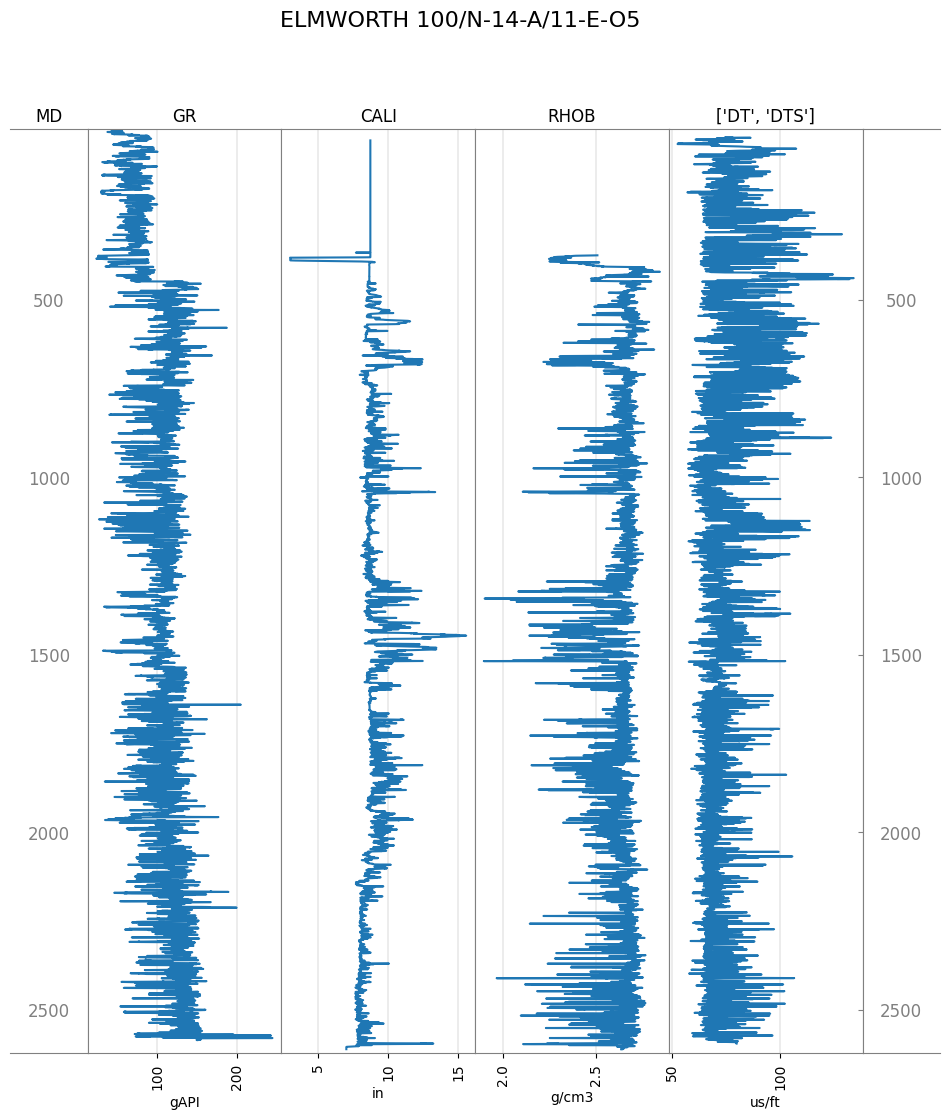

In [27]:
tracks = ['MD', 'GR','CALI', 'RHOB', ['DT', 'DTS'], 'MD']

well.plot(tracks=tracks)

## Location and CRS

In [28]:
w.location

NameError: name 'w' is not defined

## Export curves to data matrix

Make a NumPy array:

In [ ]:
w.data_as_matrix()

## Export curves to pandas

Pandas is an optional dependency. You'll need it to make this work.

In [30]:
df = well.df()

c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\welly\curve.py:470: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if self.df.index.is_numeric() and not self.df.index.empty:


In [31]:
df.head()

,CALI,DT,NPHI_SAN,NPHI_LIM,NPHI_DOL,DPHI_LIM,DPHI_SAN,DPHI_DOL,M2R9,M2R6,M2R3,M2R2,M2R1,GR,SP,PEF,DRHO,RHOB
DEPT,,,,,,,,,,,,,,,,,,
20.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='DEPT'>

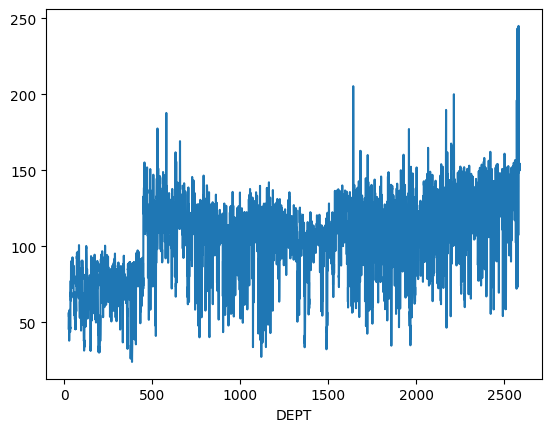

In [32]:
df.GR.plot()

This also gives us another path to getting a matrix:

In [34]:
well.df().values

c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\welly\curve.py:470: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if self.df.index.is_numeric() and not self.df.index.empty:


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(26033, 18))

You'll have to get depth separately:

In [35]:
well.df().index.values

c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\welly\curve.py:470: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if self.df.index.is_numeric() and not self.df.index.empty:


array([  20.1,   20.2,   20.3, ..., 2623.1, 2623.2, 2623.3],
      shape=(26033,))

To get the UWI of the well as well, e.g. if you want to combine multiple wells (maybe using `welly.Project.df()`):

In [36]:
df = well.df(uwi=True)

c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\welly\curve.py:470: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if self.df.index.is_numeric() and not self.df.index.empty:


In [37]:
df.head()

CALI  DT  NPHI_SAN  NPHI_LIM  NPHI_DOL  DPHI_LIM  \
UWI            DEPT                                                     
100/N14A/11E05 20.1   NaN NaN       NaN       NaN       NaN       NaN   
               20.2   NaN NaN       NaN       NaN       NaN       NaN   
               20.3   NaN NaN       NaN       NaN       NaN       NaN   
               20.4   NaN NaN       NaN       NaN       NaN       NaN   
               20.5   NaN NaN       NaN       NaN       NaN       NaN   

                     DPHI_SAN  DPHI_DOL  M2R9  M2R6  M2R3  M2R2  M2R1  GR  SP  \
UWI            DEPT                                                             
100/N14A/11E05 20.1       NaN       NaN   NaN   NaN   NaN   NaN   NaN NaN NaN   
               20.2       NaN       NaN   NaN   NaN   NaN   NaN   NaN NaN NaN   
               20.3       NaN       NaN   NaN   NaN   NaN   NaN   NaN NaN NaN   
               20.4       NaN       NaN   NaN   NaN   NaN   NaN   NaN NaN NaN   
               20.5       NaN       NaN   NaN   NaN   NaN   NaN   NaN NaN NaN   

                     PEF  DRHO  RHOB  
UWI            DEPT                   
100/N14A/11E05 20.1  NaN   NaN   NaN  
               20.2  NaN   NaN   NaN  
               20.3  NaN   NaN   NaN  
               20.4  NaN   NaN   NaN  
               20.5  NaN   NaN   NaN

### Pandas with an alias dictionary

In [38]:
alias

Total number of aliases: 8


[('copy', 'copy'),
 ('ddir', 'dir /ad /on'),
 ('echo', 'echo'),
 ('ldir', 'dir /ad /on'),
 ('ls', 'dir /on'),
 ('mkdir', 'mkdir'),
 ('ren', 'ren'),
 ('rmdir', 'rmdir')]

In [39]:
keys = ['CALI', 'Gamma', 'Density', 'Sonic', 'RLA1']
w.df(keys=keys, alias=alias, rename_aliased=True).head()

NameError: name 'w' is not defined

## Make an 'empty' well

In [ ]:
w = welly.Well()

w.header  # is empty

We can set the **UWI** and **name** of a well directly on the well object, but these are the only attributes of the well we can set in this way.

In [ ]:
w.uwi = 'foo'
w.uwi

In [ ]:
w.header

---

&copy; 2022 Agile Scientific, CC BY